In [1]:
options(repr.plot.width=5, repr.plot.height=4)

#install.packages('lmtest')
library('lmtest')
#install.packages('sandwich')
library("sandwich")

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




## Гетероскедастичность

Загрузим датасет с данными по стоимости квартир в Москве (<a href="https://raw.githubusercontent.com/bdemeshev/em301/master/datasets/flats_moscow.txt">источник</a>).

In [2]:
flats <- read.table('flats_moscow.txt', header = TRUE)
head(flats)

n,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>
1,81,58,40,6,12.5,7,1,1,1,3
2,75,44,28,6,13.5,7,1,0,1,6
3,128,70,42,6,14.5,3,1,1,1,3
4,95,61,37,6,13.5,7,1,0,1,1
5,330,104,60,11,10.5,7,0,1,1,3
6,137,76,50,9,11.0,7,1,1,1,8


Будем рассматривать зависимость цены квартиры от ее площади. По графику явно видна гетероскедастичность.

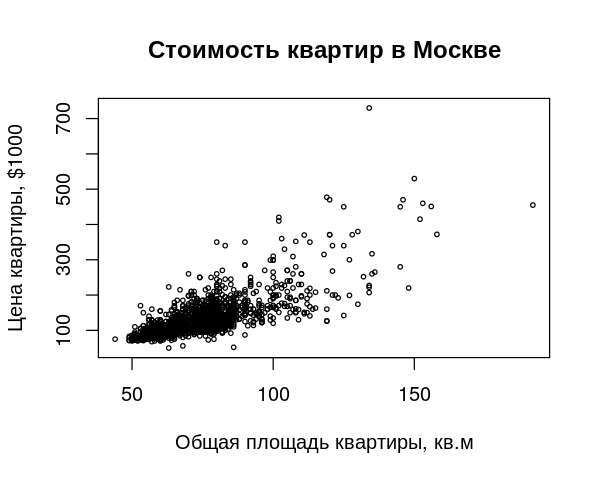

In [3]:
plot(
    flats$price ~ flats$totsp, 
    cex = 0.5,
    xlab = 'Общая площадь квартиры, кв.м',
    ylab = 'Цена квартиры, $1000',
    main = 'Стоимость квартир в Москве'
)

Обучаем регрессию для предсказания цены квартиры по ее площади

In [4]:
model <- lm(price ~ totsp, data = flats)
summary(model)


Call:
lm(formula = price ~ totsp, data = flats)

Residuals:
    Min      1Q  Median      3Q     Max 
-120.58  -17.44   -3.56   10.99  444.52 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -62.04484    3.71178  -16.72   <2e-16 ***
totsp         2.59346    0.04973   52.15   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 33.96 on 2038 degrees of freedom
Multiple R-squared:  0.5716,	Adjusted R-squared:  0.5714 
F-statistic:  2719 on 1 and 2038 DF,  p-value: < 2.2e-16


Ковариационная матрица вектора $\widehat{\theta}$ в условиях гомоскедастичности, что в данном случае не выполнено.

In [5]:
vcov(model)

,(Intercept),totsp
(Intercept),13.7772925,-0.180775186
totsp,-0.1807752,0.002473516


У нас явная гетероскедастичность, проверим это критериями

In [6]:
bptest(model)
gqtest(price ~ totsp, data = flats, fraction = 0.2, order.by = ~ totsp)


	studentized Breusch-Pagan test

data:  model
BP = 201.95, df = 1, p-value < 2.2e-16



	Goldfeld-Quandt test

data:  price ~ totsp
GQ = 8.2121, df1 = 814, df2 = 814, p-value < 2.2e-16
alternative hypothesis: variance increases from segment 1 to 2


Правильную оценку ковариационной матрицы вектора $\widehat{\theta}$ в условиях гетероскедастичности позволяет получить функция `vcovHC`. Возможные следующие виды оценок:

`type = c("HC3", "const", "HC", "HC0", "HC1", "HC2", "HC4", "HC4m", "HC5")`

Справка по функции:

In [7]:
?vcovHC

Посчитаем эту оценку

In [8]:
vcovHC(model)

,(Intercept),totsp
(Intercept),61.7662920,-0.89503034
totsp,-0.8950303,0.01303563


Правильные значения таблицы свойств коэффициентов в условиях гетероскедастичности можно получить, передав явно оценку ковариационной матрицы

In [9]:
coef.table <- coeftest(model, vcov = vcovHC(model))
coef.table


t test of coefficients:

             Estimate Std. Error t value  Pr(>|t|)    
(Intercept) -62.04484    7.85915 -7.8946 4.716e-15 ***
totsp         2.59346    0.11417 22.7151 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Асимптотический доверительный интервал для коэффициентов 

In [10]:
coefci(model, vcov = vcovHC(model))

,2.5 %,97.5 %
(Intercept),-77.457655,-46.632033
totsp,2.369553,2.817372


Для примера можно его построить руками

In [11]:
ci <- data.frame(estimate = coef.table[, 1], 
                 std_err = coef.table[, 2],
                 left = coef.table[, 1] - qnorm(0.975) * coef.table[, 2],
                 right = coef.table[, 1] + qnorm(0.975) * coef.table[, 2])
ci

,estimate,std_err,left,right
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-62.044844,7.8591534,-77.448501,-46.641186
totsp,2.593462,0.1141737,2.369686,2.817239


Рассмотрим регрессию, задаваемую формулой `price ~ totsp + livesp + dist`. С помощью критерия Вальда проверим гипотезу о незначимости признаков `livesp`, `dist`.

In [12]:
model_2 <- lm(price ~ totsp + livesp + dist, data = flats)
waldtest(model, model_2, vcov = vcovHC(model_2))

Res.Df,Df,F,Pr(>F)
<dbl>,<dbl>,<dbl>,<dbl>
2038,NA,NA,NA
2036,2,158.2786,1.281947e-64
